In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

parent_directory = str(Path().resolve().parent)
parent_directory

import os,sys 
script_path = os.path.abspath("../src")  # Adjust the path
sys.path.append(script_path)
print(parent_directory)

/Users/yiminglin/Documents/Codebase/doc-provenance


In [2]:
import json 
import tiktoken

def read_json(path):
    if not os.path.exists(path):
        return None
    with open(path, "r", encoding="utf-8") as file:
        data = json.load(file)
    return data

def count_tokens(text, model="gpt-4o-mini"):
    encoder = tiktoken.encoding_for_model(model)  # Get the tokenizer for the specific model
    tokens = encoder.encode(text)  # Encode text into tokens
    return len(tokens)

In [32]:
def get_results(data_path, result_folder_path, sufficient_provenance_strategy, minimal_provenance_strategy):
    objects = read_json(data_path)
    results = {}
    strategy = sufficient_provenance_strategy + '_' + minimal_provenance_strategy
    i = 0
    for o in objects:
        i += 1
        title = o['id']
        result_path = result_folder_path + str(i) + '_' + str(title) + '_'  + strategy + '.json'
        if not os.path.exists(result_path):
            # if i <= 500:
            #     print('path not exist:', i)
            continue
        result = read_json(result_path)
        if 'tokens' not in result:
            # if i <= 500:
            #     print('result not exist:', i)
            continue
        r = {}
        #print(i, strategy)
        r['document_size'] = result['document_size']
        r['provenance_size'] = result['provenance_size']
        r['time'] = result['time']
        r['tokens'] = result['tokens']
        results[i] = r

    return results        

In [35]:
#nl_dev 

sufficient_provenance_strategy_pool = ['LLM_score_sufficient_bottem_up','LLM_score_sufficient_top_down','embedding_sufficient_top_down','embedding_sufficient_bottem_up', 'divide_and_conquer_sufficient']
minimal_provenance_strategy_pool = ['exponential_greedy','sequential_greedy','null']

data_path = parent_directory + '/data/natural-questions_nq-dev-full.json'
result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/nl_dev/results/'

size_ratios = {}

for sufficient_provenance_strategy in sufficient_provenance_strategy_pool:
    for minimal_provenance_strategy in minimal_provenance_strategy_pool:
        strategy = sufficient_provenance_strategy + '_' + minimal_provenance_strategy
        if minimal_provenance_strategy != 'null':
            continue
        print(sufficient_provenance_strategy, minimal_provenance_strategy)
        results = get_results(data_path, result_folder_path, sufficient_provenance_strategy, minimal_provenance_strategy)
        print(len(results)) 
        avg_provenance_size = 0
        avg_size_ratio = 0
        avg_time = 0
        avg_in_tokens = 0
        avg_out_tokens = 0
        size_ratio_list = []
        for rid, result in results.items():
            size_ratio = result['provenance_size']/result['document_size']
            provenance_size = result['provenance_size']
            time = result['time']
            in_tokens = result['tokens'][0]
            out_tokens = result['tokens'][1] 

            avg_provenance_size += provenance_size
            avg_size_ratio += size_ratio
            avg_time += time 
            avg_in_tokens += in_tokens
            avg_out_tokens += out_tokens

            if size_ratio > 0.9:
                print('large size ratio:', rid)

            size_ratio_list.append(size_ratio)

            # print(rid) 
            # print('document_size, provenance_size:', result['document_size'], result['provenance_size'])
            # print('time:', result['time'])
            # print('tokens:', result['tokens'])
            # break
        avg_provenance_size /= len(results)
        avg_size_ratio /= len(results)
        avg_time /= len(results)
        avg_in_tokens /= len(results)
        avg_out_tokens /= len(results)
        print('provenance_size, size_ratio:', avg_provenance_size, avg_size_ratio)
        print('time:', avg_time)
        print('tokens:', avg_in_tokens, avg_out_tokens)
        size_ratios[strategy] = size_ratio_list
    #break
                

LLM_score_sufficient_bottem_up null
354
large size ratio: 34
large size ratio: 74
large size ratio: 80
large size ratio: 82
large size ratio: 89
large size ratio: 105
large size ratio: 112
large size ratio: 145
large size ratio: 157
large size ratio: 272
large size ratio: 296
large size ratio: 300
large size ratio: 327
large size ratio: 341
large size ratio: 351
large size ratio: 364
large size ratio: 365
large size ratio: 366
large size ratio: 374
large size ratio: 387
large size ratio: 404
large size ratio: 421
large size ratio: 424
large size ratio: 448
large size ratio: 449
large size ratio: 471
large size ratio: 483
large size ratio: 490
provenance_size, size_ratio: 2123.2203389830506 0.2592550304811867
time: 5.507059711520955
tokens: 12689.75141242938 123.24011299435028
LLM_score_sufficient_top_down null
351
large size ratio: 4
large size ratio: 13
large size ratio: 20
large size ratio: 23
large size ratio: 31
large size ratio: 34
large size ratio: 42
large size ratio: 48
large s

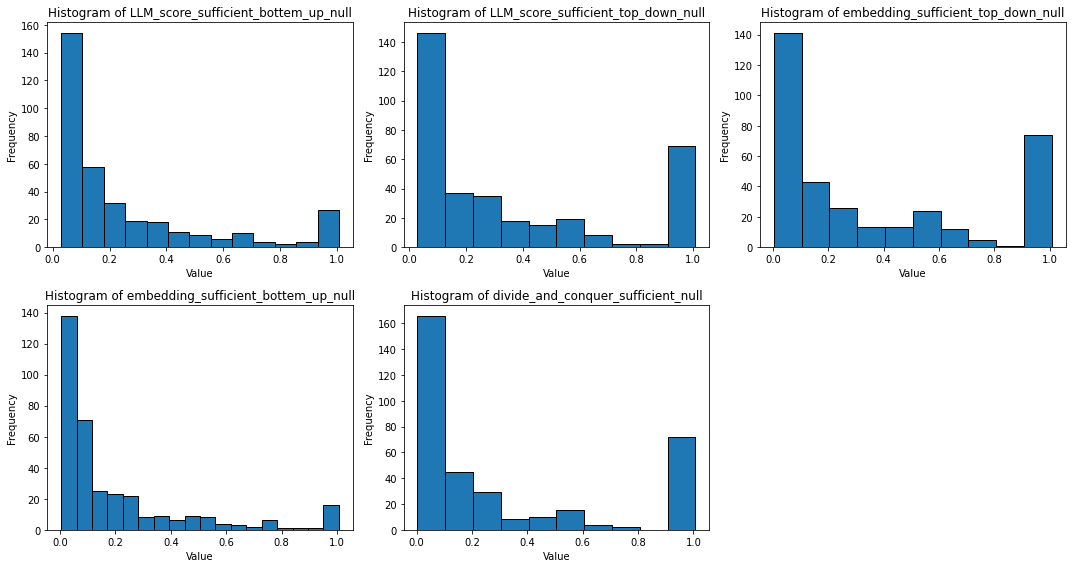

In [24]:
import matplotlib.pyplot as plt

# Prepare your strategies
plots = []
titles = []

for sufficient_provenance_strategy in sufficient_provenance_strategy_pool:
    for minimal_provenance_strategy in minimal_provenance_strategy_pool:
        if minimal_provenance_strategy != 'null':
            continue
        strategy = sufficient_provenance_strategy + '_' + minimal_provenance_strategy
        a = size_ratios[strategy]
        plots.append(a)
        titles.append(strategy)

# Set up subplots
n = len(plots)
cols = 3  # adjust columns as needed
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, (a, title) in enumerate(zip(plots, titles)):
    axes[i].hist(a, bins='auto', edgecolor='black')
    axes[i].set_title(f'Histogram of {title}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide any extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
